# Citibike Ridership Modeling

This notebook contains the final models for Citibike Ridership as well as a brief description of iterations and grid searches performed to get to these final models. Full backup, including grid searches and other details, can be found in:
- **Overall Ridership**: notebooks/citibike_arima.ipynb
- **Neighborhood Level Modeling**: notebooks/citibike_arima_neighborhood.ipynb

# Modeling Summary

These models rely on statsmodels SARIMAX toolkit to train time series models and perform predictions from actual ridership data. The 'S' is need to appropriately capture seasonality in the data while the 'X' was included in anticipation of including exogenous variables related to COVID-19.

### Goals
The main goal is to forecast expected ridership for the overall system and by neighborhood for 2022. A secondary objective is to say at what points in the year ridership is expected to peak and trough. Given this objective, I will need at least one year of data to train the model and a year to test it.


### Evaluation 
Models will be evaluated based primarily on Explained Variance, MAE, and RMSE, with R2 also among the results printed. The primary metric is Explained Variance. This is because we care about model accuracy and Explained Variance is a good catch-all metric in this regard. Grid searches were performed based on maximizing Explained Variance.

### Weekly vs. Daily
The first model attempted to use daily data to create the yearly forecast. This performed poorly for a couple reasons: 
- ARIMA models are not well suited to using daily data to create such long-term forecasts.
- There are two seasonal components to the data: the yearly summer spike, which follows warmer weather, in addition to the weekly cadence that goes with commuting. ARIMA doesn't support seasonal lags as high as 365 so ultimately I was unable to appropriately capture these affects and the models performed poorly.

Further details can be found in the backup notebook (linked above). Only one daily model is shown below as an example.


### Covid-19
The start of the COVID-19 pandemic in March 2020 resulted in a precipitous decline in ridership in 2020 before recovery to record-breaking levels in 2021. Until I control for this by adding exogenous variables to the model, I have gone back and forth on how best to deal with this:
- **Final approach**: include COVID data in the training set. There are still enough months in the training set after this to approximate a "normalized environment". The risk is a slight underforecasting of future months, but still performs reasonably well. Another benefit is that the train / test splits will be the same when incorporating the COVID-19 controls as a follow-up.
- **Other approach**: exclude COVID from the training set. While this produces a slightly better performing model overall, certain neighborhoods that have had a slower return in ridership and get really aggressive forecasts as a result. Full details for this alternative approach can be found here (https://github.com/marvelje/citibike_ridership_project/blob/main/support_notebooks/citibike_arima.ipynb) and here (https://github.com/marvelje/citibike_ridership_project/blob/main/support_notebooks/citibike_arima_neighborhood.ipynb)

In [1]:
# Standard imports

import pandas as pd
import geopandas as gpd
import contextily as cx
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from scipy.fft import fft, fftfreq, fftshift
import scipy
import itertools
from ast import literal_eval

# Set style
plt.style.use('seaborn')

In [2]:
# Import modeling util functions

from util.modeling_util import run_model, neighborhood_grid_search, dickey_fuller, \
                               process_neighborhood, report_metrics, plot_results

In [3]:
# Modeling

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import statsmodels.graphics.tsaplots as tsa

import pmdarima as pm
from pmdarima import model_selection
from pmdarima.utils import decomposed_plot
from pmdarima.arima import decompose
from pmdarima.arima.stationarity import ADFTest

from sklearn.linear_model import LinearRegression
from sklearn import metrics

#### Formulas

In [4]:
def run_final_model(df_results_, df, neighborhood):
    '''
    Runs final model for each neighborhood off the full dataset (as opposed to just the trianing set.
    Stores new model in df_results.
    Inputs:
        - The results dataframe
        - The neighborhood dataframe
        - The neighborhood name
    Returns: df_results with final model
    '''
    order = df_results_.loc[neighborhood, 'order']
    s_order = df_results_.loc[neighborhood, 'seasonal_order']
    
    mod = SARIMAX(df['ride_count_log'], order=order, seasonal_order=s_order).fit(maxiter=1000, disp=False)
    
    df_results_.loc[neighborhood, 'model'] = mod
    
    return df_results_

#### Data import

In [5]:
# Import clean dataset

df_citibike = pd.read_csv('./clean_data/final_clean_ridership.csv', low_memory=False)

In [6]:
# Convert starttime to date and set as index

df_citibike['starttime'] = pd.to_datetime(df_citibike['starttime'])

df_citibike.set_index('starttime', inplace=True)

In [7]:
# Sense check output

df_citibike.head()

,station_id,lat,long,ride_count,year,neighborhood,borough
starttime,,,,,,,
2013-06-01,72,40.767272,-73.993929,40,2013,Clinton,Manhattan
2013-06-01,79,40.719116,-74.006667,61,2013,SoHo-TriBeCa-Civic Center-Little Italy,Manhattan
2013-06-01,82,40.711174,-74.000165,6,2013,Chinatown,Manhattan
2013-06-01,83,40.683826,-73.976323,32,2013,Fort Greene,Brooklyn
2013-06-01,116,40.741776,-74.001497,53,2013,Hudson Yards-Chelsea-Flatiron-Union Square,Manhattan


In [8]:
# Create the daily file

daily_ridership = df_citibike[['ride_count']].resample('1D').sum()

# Backfill dates with 0 rides (logic for this change in EDA notebook)
daily_ridership['ride_count'] = daily_ridership['ride_count'].replace(to_replace=0, method='bfill')

In [9]:
# Define Train / Test split time

test_start = '2020-11-01'

## Naive Baseline

These models will take two approaches to build a naive starting point:
- Take average of the train data to predict the test
- Fit a simple linear regression

The testing data will be from October 2020 to October 2021. Testing data is one year as that's the time frame I'm interesting in forecasting.

#### Average Baseline

In [10]:
# Inserting a time period track for our naive models

daily_ridership.insert(0, 't', range(len(daily_ridership)))

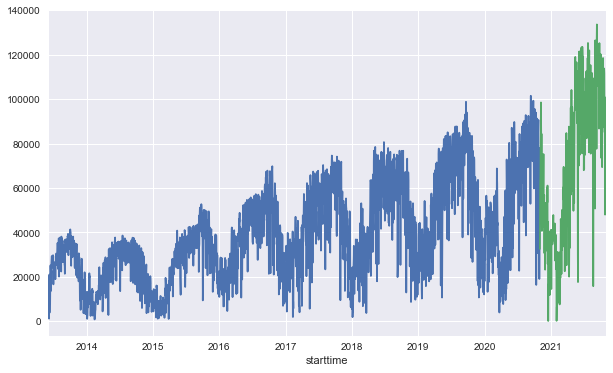

In [11]:
# Define bounds of train / test

daily_ridership['future'] = (daily_ridership.index >= test_start).astype('int')

# Now plot
plt.figure(figsize=(10,6))
daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].plot()
daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot()
plt.show();

In [12]:
# Creating train test splits for our naive models

X_train = daily_ridership.loc[daily_ridership.future == 0, 't'].values.reshape(-1, 1)
X_test = daily_ridership.loc[daily_ridership.future == 1, 't'].values.reshape(-1, 1)

# The train set is the actual value in the series
y_train = daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].values
y_test = daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].values

In [13]:
# Naive baseline prediction, will take the average of the train data

y_preds = daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].mean()

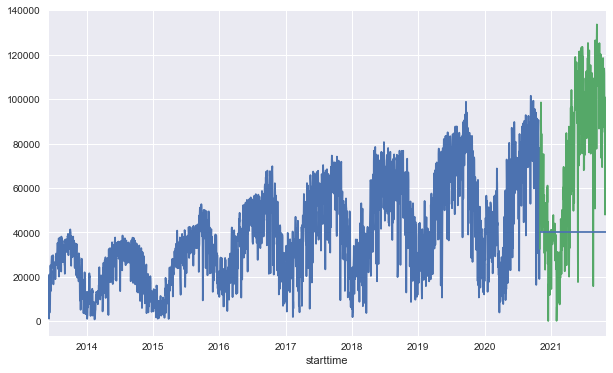

In [14]:
# Plot the baseline prediction

plt.figure(figsize=(10,6))
daily_ridership.loc[daily_ridership.future == 0, 'ride_count'].plot()
daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].plot()

# Predictions go here
plt.hlines(y=y_preds,
          xmin=daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].index[0],
          xmax=daily_ridership.loc[daily_ridership.future == 1, 'ride_count'].index[-1])


plt.show();

In [15]:
# Show results of first naive model

y_preds = [y_preds] * len(y_test)

results = report_metrics(y_test, y_preds, True)

Explained Variance: 0.0000
MAE: 38,833.0573
RMSE: 47,228.7920
r^2: -0.9237


As expected, very poor performance across the key metrics

#### Simple Linear Regression

In [16]:
# Fit the linear model

lr = LinearRegression()
lr.fit(X_train, y_train)
y_preds_lr = lr.predict(X_test)
y_trend_lr = lr.predict(X_train)

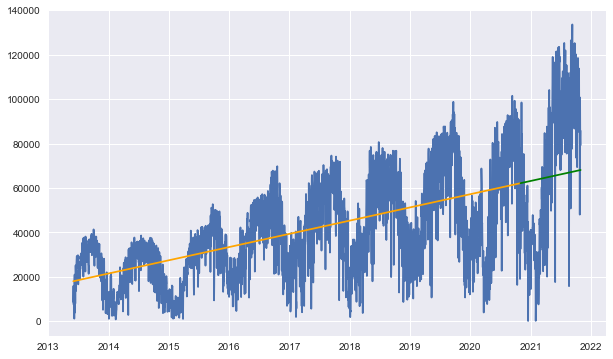

In [17]:
# Plot results

plt.figure(figsize=(10,6))
plt.plot(daily_ridership['ride_count'])
plt.plot(daily_ridership.loc[daily_ridership.future == 0].index, y_trend_lr, color='orange')
plt.plot(daily_ridership.loc[daily_ridership.future == 1].index, y_preds_lr, color='green')
plt.show()

In [18]:
# Evaluate linear regression

results = report_metrics(y_test, y_preds_lr, True)

Explained Variance: 0.0734
MAE: 29,922.2116
RMSE: 33,672.3303
r^2: 0.0221


Conclusions: The linear regression is slightly better, but only captures the inherent upward trend without further controls. While each of these models performs poorly, they give us a benchmark to compare against. Explained Variance of 7% is our baseline.

## First SARIMA model

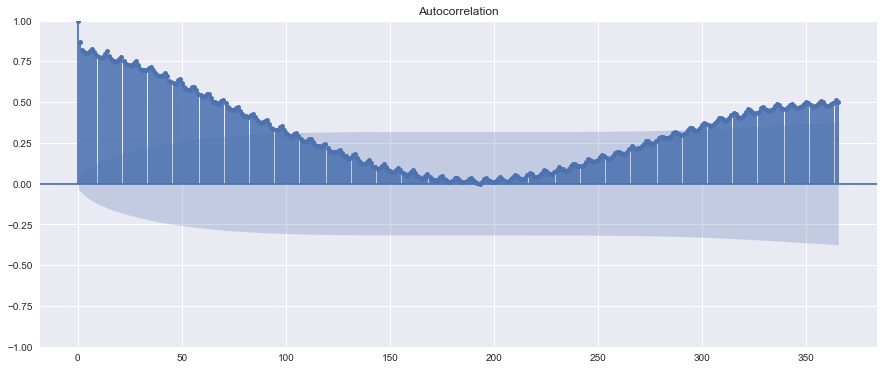

In [19]:
# In the ACF plot, you can clearly see the yearly seasonality in this data
# Less obvious (because of the scale) is the weekly trend as well

fig, ax = plt.subplots(figsize=(15,6))

tsa.plot_acf(daily_ridership['ride_count'], lags=365, ax=ax);

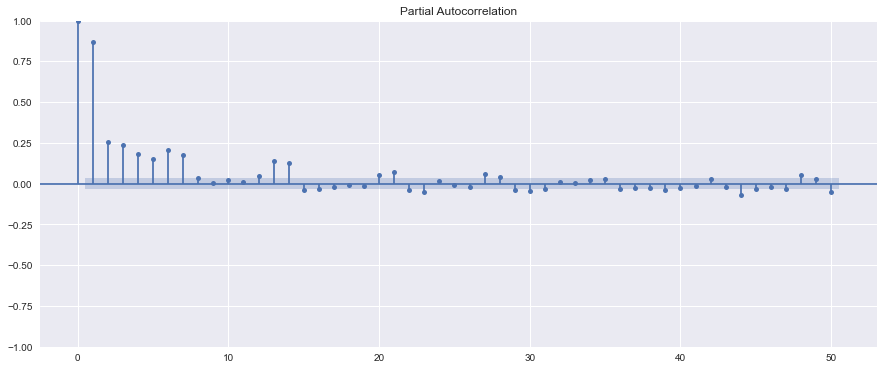

In [20]:
# In the PACF plot, you see more of the weekly trend instead of the seasonal trend

fig, ax = plt.subplots(figsize=(15,6))

tsa.plot_pacf(daily_ridership['ride_count'], method='ywm', lags=50, ax=ax);

In [21]:
# Run one ARIMA model on the daily data for illustrative purposes to how poorly it fits

seas_arima = ARIMA(daily_ridership.loc[daily_ridership.future == 0]['ride_count'], 
                   order = (1, 1, 1), seasonal_order=(0, 0, 0, 365))

baseline_sarima = seas_arima.fit()

In [22]:
# Create predictions based on the model and store it in a new dataframe

actuals = daily_ridership.loc[daily_ridership.future == 1]['ride_count']
preds = baseline_sarima.forecast(steps = len(daily_ridership.loc[daily_ridership.future == 1]))


# Print metric summary

results = report_metrics(actuals, preds, True)

Explained Variance: -0.0002
MAE: 31,265.6581
RMSE: 35,075.7551
r^2: -0.0611


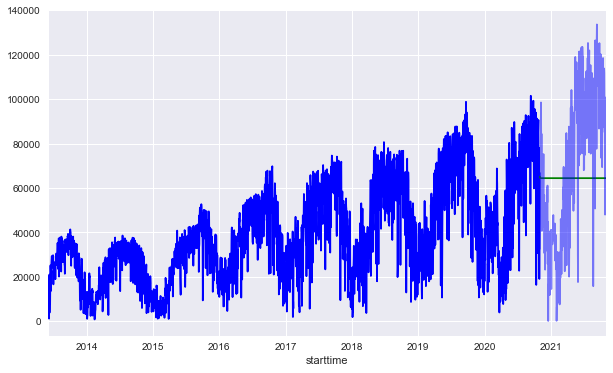

In [23]:
# Plot the results

plot_results(daily_ridership, preds, False)

Not good! Daily data is clearly unsuitable for making yearly predictions.

## Weekly Ridership

- Now, will move on to the core of the modeling, which will involve re-aggregated weekly data

In [24]:
# Resample to weekly

weekly_ridership = daily_ridership.resample('W-SUN').sum().drop('future', axis=1)

weekly_ridership.drop('t', axis=1, inplace=True)

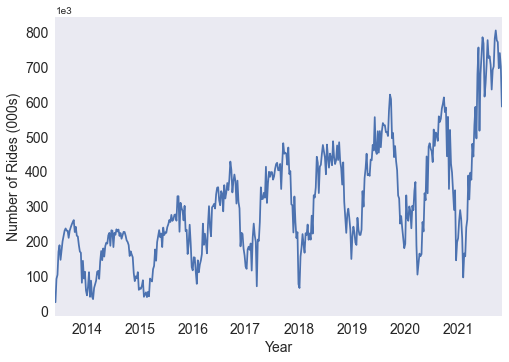

In [25]:
# Plot the new data

fig, ax = plt.subplots();

weekly_ridership['ride_count'].plot(ax=ax)
ax.grid(False)
ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax.set_ylabel('Number of Rides (000s)', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax.set_xlabel('Year', fontsize=14);
# A lot cleaner than the daily data

In [28]:
# Create future time stamp

weekly_ridership['future'] = (weekly_ridership.index >= test_start).astype('int')

In [29]:
# Log transform ridership (will explore the impact of doing this below)

weekly_ridership['ride_count_log'] = weekly_ridership['ride_count'].apply(lambda x: np.log(x))

In [30]:
# Create train test splits

train_weekly = weekly_ridership[weekly_ridership['future'] == 0]['ride_count_log']
test_weekly = weekly_ridership[weekly_ridership['future'] == 1]['ride_count_log']

In [31]:
# RUn dickey fuller on unadjusted training data

dickey_fuller(weekly_ridership[weekly_ridership['future'] == 0]['ride_count'], False, True)

Data is stationary. P-value of 0.0248


(True, 0.024770590964636706)

The dickey fuller test on the regular ridership data is actually suggesting it's already stationary (p value of 2.5%). However, it's close enough that I feel like it can only help model performance if we make this change.

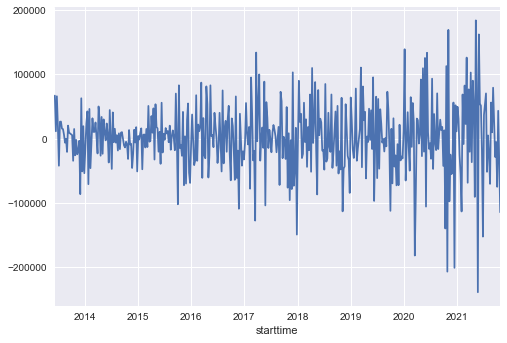

In [32]:
# Plot the 1d diff to visualizing inspect for stationarity

weekly_ridership['1d_diff'] = weekly_ridership['ride_count'].diff()

weekly_ridership['1d_diff'].plot();

The 1d differencing on the regular ridership count appears to be significantly more stationary just from the visual inspection. However, we still observe that variance is increasing through time, further evidence for log transformation.

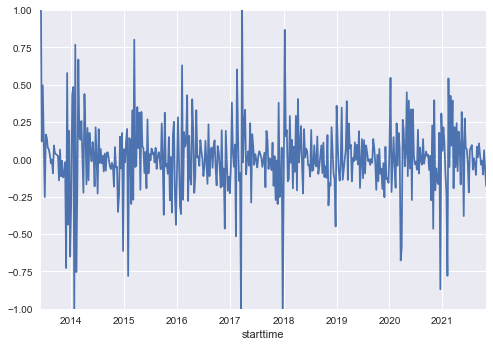

In [33]:
# The log of ride count with the 1d diff looks very stationary, plus we have the obvious 52 week 
# seasonality factor to consider as an input

fig, ax = plt.subplots()

ax.set_ylim([-1, 1])

weekly_ridership['ride_count_log'].diff().plot(ax=ax);

In [37]:
# Dickey fuller on the log transformed, 1d difference data is highly stationary.

dickey_fuller(weekly_ridership[weekly_ridership['future'] == 0]['ride_count_log'].diff().dropna(), False, True)

Data is stationary. P-value of 0.0000


(True, 5.340169151876534e-10)

In [38]:
# First seasonal model without grid search, using 52 weeks lag

seas_mod_weekly = SARIMAX(train_weekly, order=(1, 1, 1), seasonal_order=(1, 1, 0, 52)).fit(disp=False)

# Create a dataframe to store the weekly predictions
weekly_future_df = weekly_ridership.loc[weekly_ridership.future == 1].copy()

# Create a forecast for the length of the test set
weekly_future_df['baseline_seas'] = seas_mod_weekly.forecast(steps = len(test_weekly))

results = report_metrics(test_weekly, weekly_future_df['baseline_seas'], True)

Explained Variance: 0.5567
MAE: 0.2823
RMSE: 0.3673
r^2: 0.5290


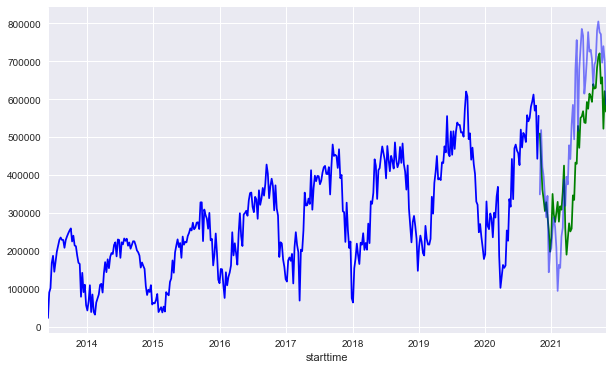

In [39]:
# Plot the results

plot_results(weekly_ridership, weekly_future_df['baseline_seas'], True)

**Model Summary**

Explained variance of 56% and R2 of 0.53 is pretty good without grid searching! Appears to underestimate 2021 ridership. Tuning some of the parameters likely will result in better performance.

#### Grid Search

- Now that it seems like the model performs reasonably well on the weekly data, I'll perform a grid search to determine optimal order / seasonal order.
- I will be looking to optimize Explained Variance.
- I will keep the pdq, and PDQ terms between 0 and 1 unless the model is performing poorly or it seems like there's a compelling reason to use a term greater than 1.

In [ ]:
# Create tuples of every p, d, q combination for 0 and 1
# Note: code below takes ~30 minutes to run

p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]

# Set initial EV to some initially low amount
best_ev = 0

for param in pdq:
    for param_seasonal in seasonal_pdq: 
        mod = SARIMAX(train_weekly, order=param, seasonal_order=param_seasonal).fit(maxiter=1000, disp=False)
        
        forecast = mod.forecast(steps = len(test_weekly))
        # Note: I want the model that maximizes explained variance on the actual ridership data
        # The tradeoff is very slightly worse performance on log transformed data in return
        # for substantial improvements on actual ridership data
        ev = metrics.explained_variance_score(np.exp(test_weekly), np.exp(forecast))

        if ev > best_ev:
            best_ev = ev
            best_order = param
            best_s_order = param_seasonal

In [29]:
# Display results of grid search

print(best_order, best_s_order)

In [38]:
# Evaluate model with grid search results

seas_mod_best = SARIMAX(train_weekly, order=(1, 1, 0), seasonal_order=(0, 1, 1, 52)).fit(disp=False)

weekly_future_df['best_seas'] = seas_mod_best.forecast(steps = len(test_weekly))

# Note (0, 1, 1) and (0, 1, 1, 52) produces similar results but without as aggressive of a 2022 projection

In [39]:
results = report_metrics(test_weekly, weekly_future_df['best_seas'], True)

Explained Variance: 0.8286
MAE: 0.1607
RMSE: 0.2220
r^2: 0.8280


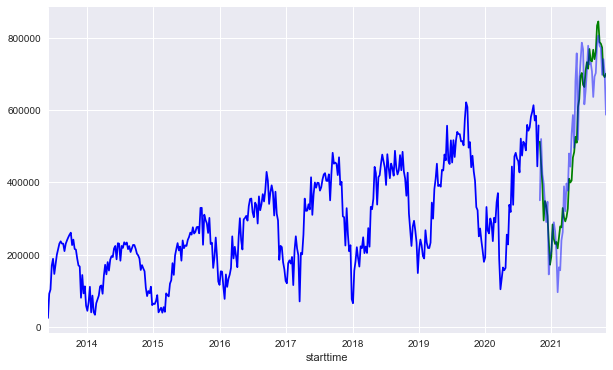

In [40]:
# Plot the results

plot_results(weekly_ridership, weekly_future_df['best_seas'], True)

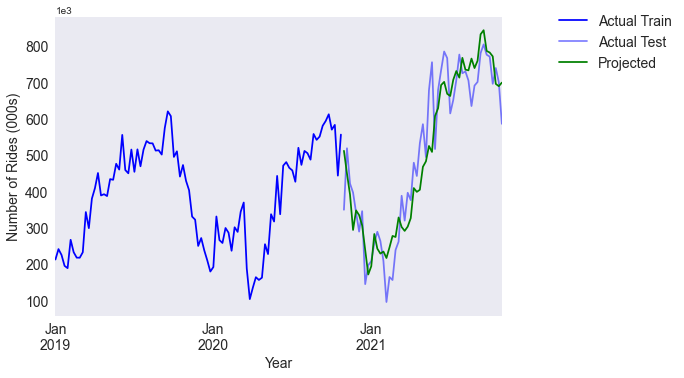

In [41]:
# Plot only more recent results

fig, ax = plt.subplots()

past = weekly_ridership[(weekly_ridership['future'] == 0) & (weekly_ridership.index > '12/31/2018')]
actual = weekly_ridership[weekly_ridership['future'] == 1]
projections = seas_mod_best.forecast(steps = len(test_weekly))

past['ride_count'].plot(ax=ax, color='blue')
actual['ride_count'].plot(ax=ax, color='blue', alpha=0.5)
np.exp(projections).plot(ax=ax, color='green')
ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax.set_ylabel('Number of Rides (000s)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.legend(['Actual Train', 'Actual Test', 'Projected'], bbox_to_anchor=(1.1, 1.05), fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.minorticks_off()
ax.grid(False);

Conclusion: zeroing out the first seasonal AR term results in significantly higher performance. Explained variance is 83% and R2 and 0.83. This feels excellent. To sense check, I will just forecast out to 2022 to ensure the trend is what we'd expect.

#### Model Evaluation

Explained variance and R2 is excellent. The only drawback to these parameters is that it produces a very aggressive 2022 forecast, although this appears to be in line with the increasing trend that we see in the data.

The risk to this forecast is that Citibike is unable to have the bikes in the system to meet this demand (they have already said that this has been an issue in 2021).

Ultimately, I'm choosing this grid searched version as my final model because it maximizes EV and produces a reasonable forecast (with the caveat just described above).

In [42]:
# Retrain the model on the full dataset and generate a 2022 prediction
seas_mod_best = SARIMAX(weekly_ridership['ride_count_log'], order=(1, 1, 0), seasonal_order=(0, 1, 1, 52)).fit(disp=False)


# Set final model = to the grid searched version
final_overall_model = seas_mod_best

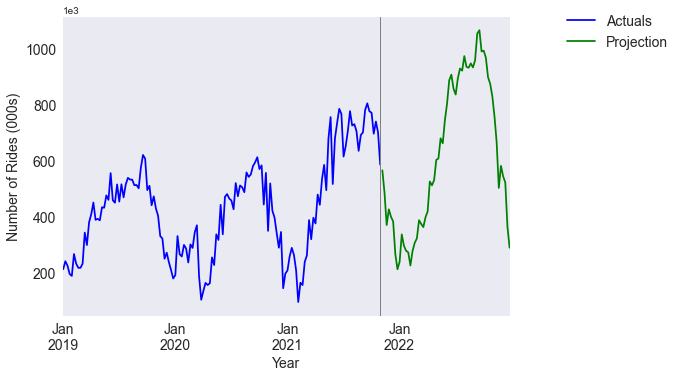

In [43]:
# Plot the 2022 projection on the fully trained model

fig, ax = plt.subplots()

# Store an abbreviated version of the actuals
actuals = weekly_ridership[weekly_ridership.index > '12/31/2018']

# Create 2022 projections
projections = final_overall_model.forecast(steps = 60)

# Unlog the projections
projections = np.exp(projections[projections.index > '10/31/2021'])

# Plot results
actuals['ride_count'].plot(ax=ax, color='blue')
projections.plot(ax=ax, color='green')
ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax.set_ylabel('Number of Rides (000s)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.legend(['Actuals', 'Projection'], bbox_to_anchor=(1.1, 1.05), fontsize=14)
plt.axvline(x='10/31/2021', color='gray', linewidth=1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.minorticks_off()
ax.grid(False);

In [44]:
# Show peak difference in ridership

print(projections.max())

print((projections.max() - actuals['ride_count'].max()) / actuals['ride_count'].max())

# Peak ridership is forecast to be nearly 1.1mm in 2021, a growth of 32% YoY

1066369.2222061427
0.32416904529690693


## Neighborhood modeling

- Below will create models for each of the neighborhoods in Manhattan. There are three steps to the process:
    - Initial model run based on best parameters for the overall dataset
    - Grid search for each of the neighborhoods
    - Manual tuning where necessary for certain neighborhoods

#### Initial Data Processing and Prep

Process neighborhood-level DataFrames
- Resample weekly
- Log transform ridership count
- Create a dataframe to store results

In [45]:
# Read in clean neighborhood list and convert to list

temp_df = pd.read_csv('./clean_data/neighborhood_list.csv', low_memory=False)

neighborhood_list = list(temp_df.iloc[:,1])

In [46]:
# Process each of the DFs in the neighborhood list

df_dict = {}

for neighborhood in neighborhood_list:
    df = process_neighborhood(df_citibike, neighborhood)
    df_dict[neighborhood] = df

In [47]:
# Resample for weekly given better performance of overall model on weekly data

for neighborhood, df in df_dict.items():
    df_dict[neighborhood] = df[['ride_count']].resample('W-SAT').sum()

In [48]:
# Add a future tag after the cut off for easy designation of train / test split

for neighborhood, df in df_dict.items():
    
    df['future'] = (df.index >= test_start).astype('int')
    
    df_dict[neighborhood] = df

In [49]:
# Create a dataframe to store neighborhood by neighborhood results

df_results = pd.DataFrame(index=neighborhood_list, columns=['model', 'order', 'seasonal_order',
                                                            'explained_variance', 'MAE', 'MSE', 'R2',
                                                            '2021_actual', '2021_predicted', 'delta', 
                                                            'requires_log'])

In [50]:
# Create another dataframe to store the predictions from each model

df_preds = pd.DataFrame(index=df_dict['Clinton'][df_dict['Clinton'].index >= test_start].index, 
                              columns=neighborhood_list)

In [51]:
# Add a column to each neighborhood dataframe with the log transformed ridership

for neighborhood, df in df_dict.items():

    df_results.loc[neighborhood, 'requires_log'] = True
    df['ride_count_log'] = df['ride_count'].apply(lambda x: np.log(x))
    df_dict[neighborhood] = df

#### First Neighborhood Model

Uses the hyperparemeters that produced the optimal overall model

In [51]:
# Run models for each neighborhood. Use parameters that performed best on overall model.
# Note: takes ~20 minutes to run

for neighborhood, df in df_dict.items():
    df_results, df_preds = run_model(df_results, df_preds, neighborhood, df, 
                                    (1, 1, 0), (0, 1, 1, 52), 
                                    df_results.loc[neighborhood, 'requires_log'])

/Users/jeffreymarvel/opt/anaconda3/envs/citibike/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/jeffreymarvel/opt/anaconda3/envs/citibike/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/Users/jeffreymarvel/opt/anaconda3/envs/citibike/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


In [52]:
# There are many neighborhoods with R2 below 0.25
# I'm looking at R2 as opposed to EV because it's a good catch-all for a poor performing model. I still want
# to maximize EV

df_results[df_results['R2'] < 0.25].shape

(15, 11)

There were a lot of suboptimal results in the first pass of the neighboorhood model. I will run a grid search to see if I can't improve these results.

#### Neighborhood Grid Search

The code below performs the same grid search run previously on the neighborhood-level data.

The code below takes ~3 hours to run. Optimal orders and seasonal_orders by neighborhood were stored and exported to save time on future runs.

In [52]:
# Create a dataframe to store the results of the grid search

df_grid_search = pd.DataFrame(index=neighborhood_list, columns=['order', 's_order', 'ev'])

In [53]:
# Define range of p, d, q, and P, D, Q for neighborhood grid search

p = q = range(0, 2)
pdq = list(itertools.product(p, [1], q))
seasonal_pdq = [(x[0], x[1], x[2], 52) for x in list(itertools.product(p, [1], q))]

In [54]:
# Run grid search on each neighborhood
# The below code is commented out because it takes ~3 hours to run

# for neighborhood, df in df_dict.items():
#     df_grid_search = neighborhood_grid_search(pdq, seasonal_pdq, neighborhood, df, df_grid_search)

In [164]:
# Save the results so we don't have to re-run the 3 hour long function again

# df_grid_search.to_csv('./results/neighborhood_grid_search2.csv')

In [55]:
# If starting from here, load neighborhood grid search

# Reading in 2nd version of the grid search after making some tweaks
df_grid_search = pd.read_csv('./results/neighborhood_grid_search2.csv', index_col=0)

# Convert order / s_orders string via literal eval
df_grid_search['order'] = df_grid_search['order'].apply(lambda x: literal_eval(x))
df_grid_search['s_order'] = df_grid_search['s_order'].apply(lambda x: literal_eval(x))

In [56]:
# Rerun COVID neighborhood models with the result of the grid search

for neighborhood, df in df_dict.items():
    df_results, df_preds = run_model(df_results, df_preds, neighborhood, df, 
                                     df_grid_search.loc[neighborhood,'order'], 
                                     df_grid_search.loc[neighborhood,'s_order'], 
                                     df_results.loc[neighborhood, 'requires_log'])

/Users/jeffreymarvel/opt/anaconda3/envs/citibike/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'


There is a non-invertible starting seasonal moving average warning. Among future neighborhood tuning, I will need to investigate why this is happening.

In [57]:
# Print results

df_results

,model,order,seasonal_order,explained_variance,MAE,MSE,R2,2021_actual,2021_predicted,delta,requires_log
Clinton,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 1, 1, 52)",0.636914,0.311512,0.392828,0.498974,706840,559498.024944,147341.975056,True
SoHo-TriBeCa-Civic Center-Little Italy,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 1, 1, 52)",0.701641,0.332055,0.413604,0.561385,1266160,989374.184704,276785.815296,True
Chinatown,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 52)",0.647519,0.224362,0.332755,0.595952,676262,595935.469043,80326.530957,True
Fort Greene,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 1, 52)",0.553827,0.359819,0.450876,0.349409,309627,236223.637078,73403.362922,True
Hudson Yards-Chelsea-Flatiron-Union Square,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 1, 1, 52)",0.600533,0.415791,0.478641,0.244369,2190634,1511209.666658,679424.333342,True
Bedford,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 0, 52)",0.455173,0.264845,0.376534,0.45501,207296,213497.443574,6201.443574,True
West Village,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 1, 52)",0.676953,0.378094,0.45012,0.520533,1571664,1171205.511703,400458.488297,True
Midtown-Midtown South,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 1, 52)",0.388214,0.496758,0.580967,-0.215665,1562113,1000899.039615,561213.960385,True
Brooklyn Heights-Cobble Hill,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(1, 1, 1, 52)",0.65575,0.321774,0.409308,0.515154,247070,194213.891919,52856.108081,True
DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 52)",0.674736,0.295316,0.390711,0.558362,537851,444663.934667,93187.065333,True


In [58]:
# Take a closer look at neighborhoods with poor performance to see if there's an opportunity to manually tune

r2_threshold = 0.25

df_tune = df_results[df_results.loc[:,'R2'] < r2_threshold]

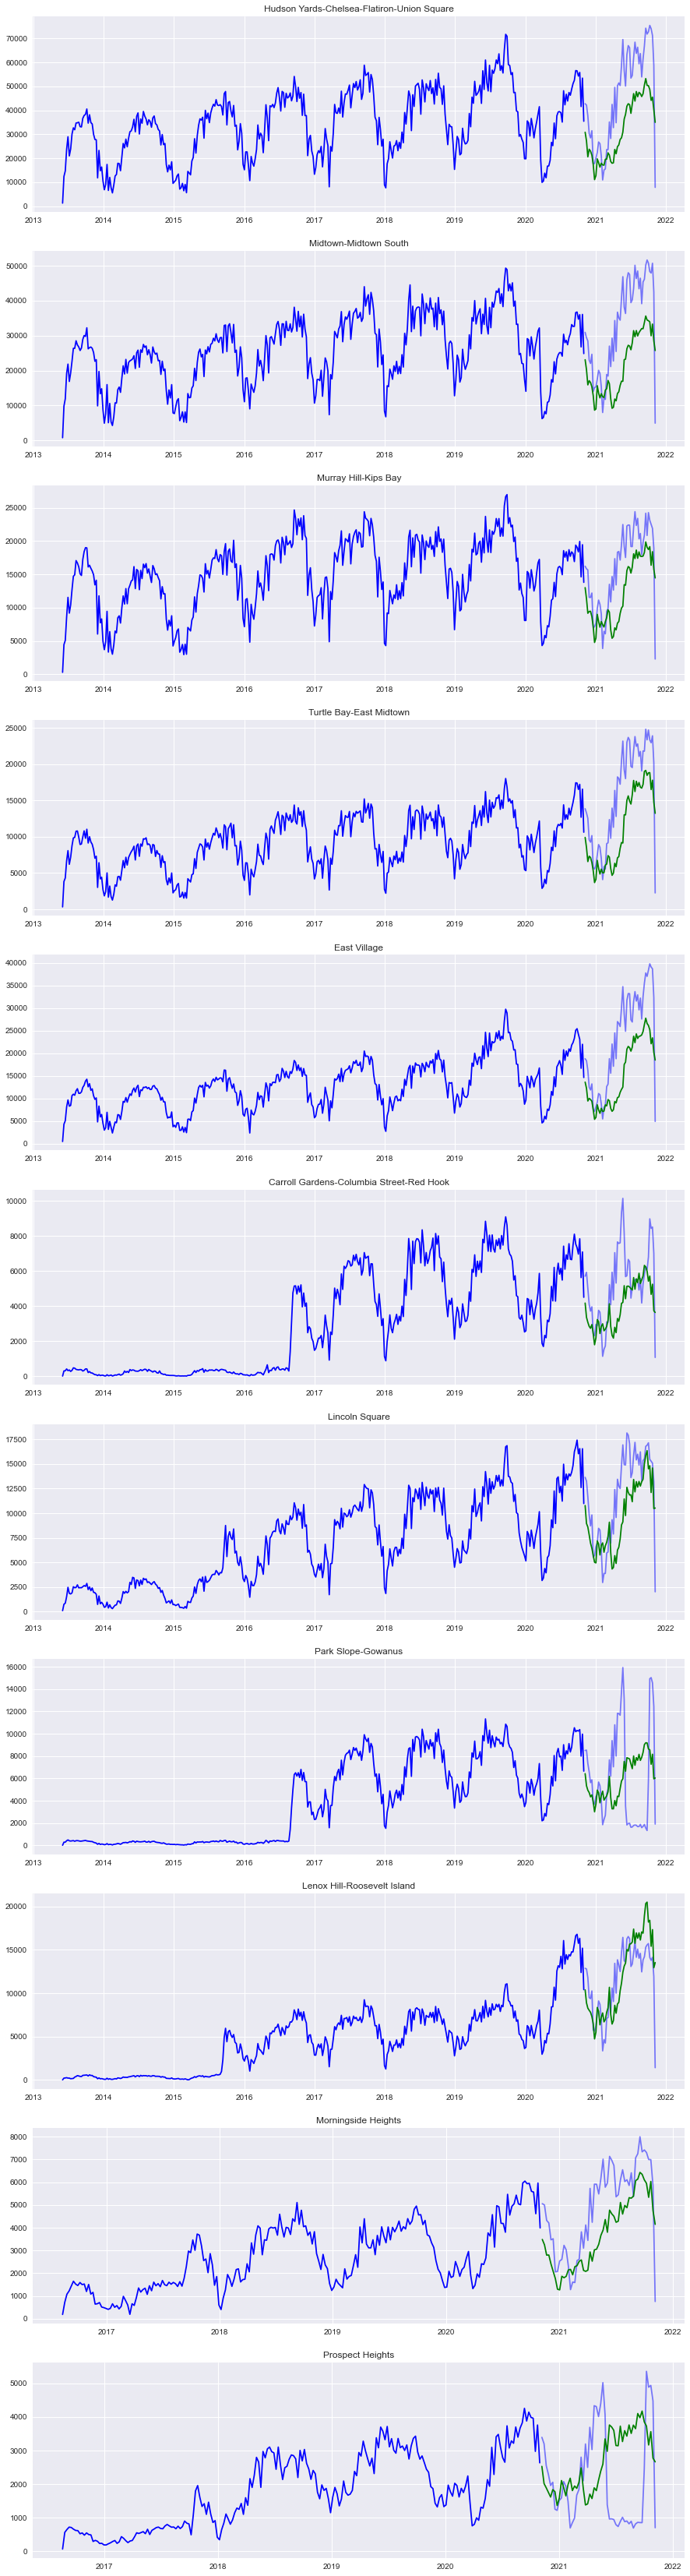

In [59]:
# Plot each of the predictions from the poor performing neighborhoods to sense check results

fig, ax = plt.subplots(nrows=(len(df_tune.index)), figsize=(15,60))

for i, neighborhood in enumerate(df_tune.index):
    ax[i].plot(df_dict[neighborhood].loc[df_dict[neighborhood].future == 0, 'ride_count'], color='blue')
    ax[i].plot(df_dict[neighborhood].loc[df_dict[neighborhood].future == 1, 'ride_count'], color='blue', 
               alpha=0.5)
    
    ax[i].plot(df_preds.loc[:,neighborhood], color='green')
    ax[i].set_title(neighborhood)

#### Neighborhood level tuning conclusions:
- **Summary**: The grid searched has improved the results as the majority have an EV above 0.5.
- For further tuning, I've decided to filter every neighborhood with an R2 below 0.25. The reason for switching to R2 is that this seems to be a nice cutoff where I can capture every neighborhood with poor EV and R2. On the other hand, there seem to be some neighborhoods with reasonable EV and low R2, and I want to make sure these are captured for further tuning as well.
- There are a few neighborhoods, mostly in Manhattan, where the model "under-predicts" ridership, likely because it has no way to anticipate the surge in ridership from people coming back into the office
    - Midtown-Midtown South, Murray Hill-Kips Bay, Turtle Bay-East Midtown, East Village, Hudson Yards
- The second category of miss is those neighborhoods with an apparent data issue. During the summer of 2021, ridership falls off for a few Brooklyn neighborhoods in an artificial way. These are:
    - Propect Heights, Park Slope-Gowanus, Carrol Gardens, Park Cemetery, Brooklyn.
- There are also some neighborhoods on the Upper East side (Yorkville, Lenox Hill, etc) where ridership has not recovered to the extent the model suggests
- Sunset Park west appears to have the opposite problem with a suspcious dual spike in ridership.

#### Next steps:
- Further tune Manhattan and UES neighborhoods
- Don't tune the neighborhoods with data issues any further (the poor metrics are due to data issues in the Testing data)
- There are a few neighborhoods that have failed to converge. I need to investigate why this is happening and potentially further tune.

#### Backup:
- I have already done the tuning in notebooks/citibike_arima_neighborhood (link below) for midtown and UES neighborhoods to try to manually improve performance. Rather than re-run those steps here, I will just skip to re-running the models based on the optimal metrics.

**Midtown**: It's clear I'm not going to be able to capture the recovery in ridership without some control for COVID. Removing the AR term and giving the model 2 MA terms does stop the donward trend in the prediction. This is the best that I can do for now. 

**UES**: For the neighborhoods where the model was materiall overprojecting, removing the differencing term actually appears to prevent the aggressive forecast. I'm still comfortable that the data is stationary without this differencing term given that the time series has been logged.

https://github.com/marvelje/citibike_ridership_project/blob/main/support_notebooks/citibike_arima_neighborhood.ipynb

In [60]:
df_tune

,model,order,seasonal_order,explained_variance,MAE,MSE,R2,2021_actual,2021_predicted,delta,requires_log
Hudson Yards-Chelsea-Flatiron-Union Square,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 1, 1, 52)",0.600533,0.415791,0.478641,0.244369,2190634,1511209.666658,679424.333342,True
Midtown-Midtown South,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 1, 52)",0.388214,0.496758,0.580967,-0.215665,1562113,1000899.039615,561213.960385,True
Murray Hill-Kips Bay,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 1, 52)",0.309899,0.369866,0.488842,0.033224,754790,572840.967217,181949.032783,True
Turtle Bay-East Midtown,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 1, 52)",0.492587,0.434055,0.53358,0.084678,753899,527690.571423,226208.428577,True
East Village,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 1, 52)",0.595387,0.45426,0.540303,0.138153,1116657,730208.373784,386448.626216,True
Carroll Gardens-Columbia Street-Red Hook,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 0, 52)",0.237625,0.373844,0.486403,0.051591,243325,188639.58116,54685.41884,True
Lincoln Square,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 0, 52)",0.359002,0.326641,0.436374,0.238873,547137,447554.4466,99582.5534,True
Park Slope-Gowanus,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 0, 52)",-0.462873,0.827196,0.989632,-0.572422,263480,280459.588277,16979.588277,True
Lenox Hill-Roosevelt Island,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 0, 52)",0.254977,0.255038,0.406269,0.248928,531047,565216.147124,34169.147124,True
Morningside Heights,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 1, 1, 52)",0.505828,0.370838,0.451759,0.24306,229144,175013.014053,54130.985947,True


In [61]:
# Define midtown and upper east side (ues) neighborhoods for further tuning

midtown_neighborhoods = ['Midtown-Midtown South', 'Murray Hill-Kips Bay', 'Turtle Bay-East Midtown', 
                         'East Village', 'Hudson Yards-Chelsea-Flatiron-Union Square']

ues_neighborhoods = ['Yorkville', 'Lenox Hill-Roosevelt Island', 'Lincoln Square']

In [62]:
# Re-run midtown models with updated tuning (source notebook with model tuning cited in section header above)

for neighborhood in midtown_neighborhoods:
    df_results, df_preds = run_model(df_results, df_preds, neighborhood, 
                                     df_dict[neighborhood], (0, 1, 2), (1, 1, 1, 52), 
                                     df_results.loc[neighborhood, 'requires_log'])

In [63]:
# Re-run UES models with updated tuning (source notebook with model tuning cited in section header above)

for neighborhood in ues_neighborhoods:
    df_results, df_preds = run_model(df_results, df_preds, neighborhood, 
                                     df_dict[neighborhood], (1, 0, 1), (1, 1, 0, 52), 
                                     df_results.loc[neighborhood, 'requires_log'])

In [64]:
# Print updated results

df_results

,model,order,seasonal_order,explained_variance,MAE,MSE,R2,2021_actual,2021_predicted,delta,requires_log
Clinton,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 1, 1, 52)",0.636914,0.311512,0.392828,0.498974,706840,559498.024944,147341.975056,True
SoHo-TriBeCa-Civic Center-Little Italy,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 1, 1, 52)",0.701641,0.332055,0.413604,0.561385,1266160,989374.184704,276785.815296,True
Chinatown,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 52)",0.647519,0.224362,0.332755,0.595952,676262,595935.469043,80326.530957,True
Fort Greene,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 1, 52)",0.553827,0.359819,0.450876,0.349409,309627,236223.637078,73403.362922,True
Hudson Yards-Chelsea-Flatiron-Union Square,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 2)","(1, 1, 1, 52)",0.531315,0.342462,0.440341,0.360459,2190634,1676196.61423,514437.38577,True
Bedford,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 0, 52)",0.455173,0.264845,0.376534,0.45501,207296,213497.443574,6201.443574,True
West Village,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 1, 52)",0.676953,0.378094,0.45012,0.520533,1571664,1171205.511703,400458.488297,True
Midtown-Midtown South,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 2)","(1, 1, 1, 52)",0.357645,0.496374,0.576979,-0.199033,1562113,974033.065542,588079.934458,True
Brooklyn Heights-Cobble Hill,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(1, 1, 1, 52)",0.65575,0.321774,0.409308,0.515154,247070,194213.891919,52856.108081,True
DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 52)",0.674736,0.295316,0.390711,0.558362,537851,444663.934667,93187.065333,True


In [65]:
df_results[df_results['explained_variance'] < 0.5].shape

(13, 11)

#### Neighborhood Conclusions:

- Only 13 out of 41 neighborhoods have explained variance under 50%. The actual number of numbers is probably lower (probably < 10) given the known data issues with some neighborhoods in Brooklyn.
- These are decent results for my business objective and will allow us to paint a broad picture of where ridership is expected to grow in the city.
- Next steps will be:
    - Potentially fix the data issues for the Brooklyn neighborhoods
    - Incorporate COVID data to improve model performance

In [66]:
# final_results = df_results

# Set as version 2 after making tweaks to the grid search (didn't want to lose the first version of the results)
# final_results.to_csv('./results/neighborhood_results2.csv')

In [50]:
# Read in final results if starting from here and re-running notebook
# Again, reading in 2nd version per notes above

final_results = pd.read_csv('./results/neighborhood_results2.csv')

final_results['order'] = final_results['order'].apply(lambda x: literal_eval(x))
final_results['seasonal_order'] = final_results['seasonal_order'].apply(lambda x: literal_eval(x))

# Set neighborhood as the index
final_results.rename(columns={'Unnamed: 0': 'neighborhood'}, inplace=True)
final_results.set_index('neighborhood', inplace=True)

### Run final model on full neighborhood datasets

- The code below re-trains the model on the full time series in order to generate 2022 predictions

In [67]:
for neighborhood, df in df_dict.items():
    
    # Filtering for 10/31/2021 given a quirk in how the data was rolled up
    df_filtered = df[df.index < '10/31/2021']
    
    # Save new model in final results
    final_results = run_final_model(final_results, df_filtered, neighborhood)

## Generate 2022 forecast
- Next step is to generate the 2022 forecast for the overall ridership and neighborhood level models
- I will need to forecast out slightly more than one year in order to go through the end of 2022

#### Neighborhood 2022 Forecast

In [68]:
# Create an empty forecast dataframe

# Calibrated forecast steps to go through the end of 2022
forecast_steps = 60

df_forecast = pd.DataFrame(index=final_results.loc['Clinton', 'model'].forecast(steps=forecast_steps).index,
                           columns=neighborhood_list)

In [69]:
# Add the forecast from each model to the dataframe

for neighborhood in neighborhood_list:
    
    model = final_results.loc[neighborhood, 'model']
    forecast = np.exp(model.forecast(steps = forecast_steps))
    
    df_forecast.loc[:,neighborhood] = forecast

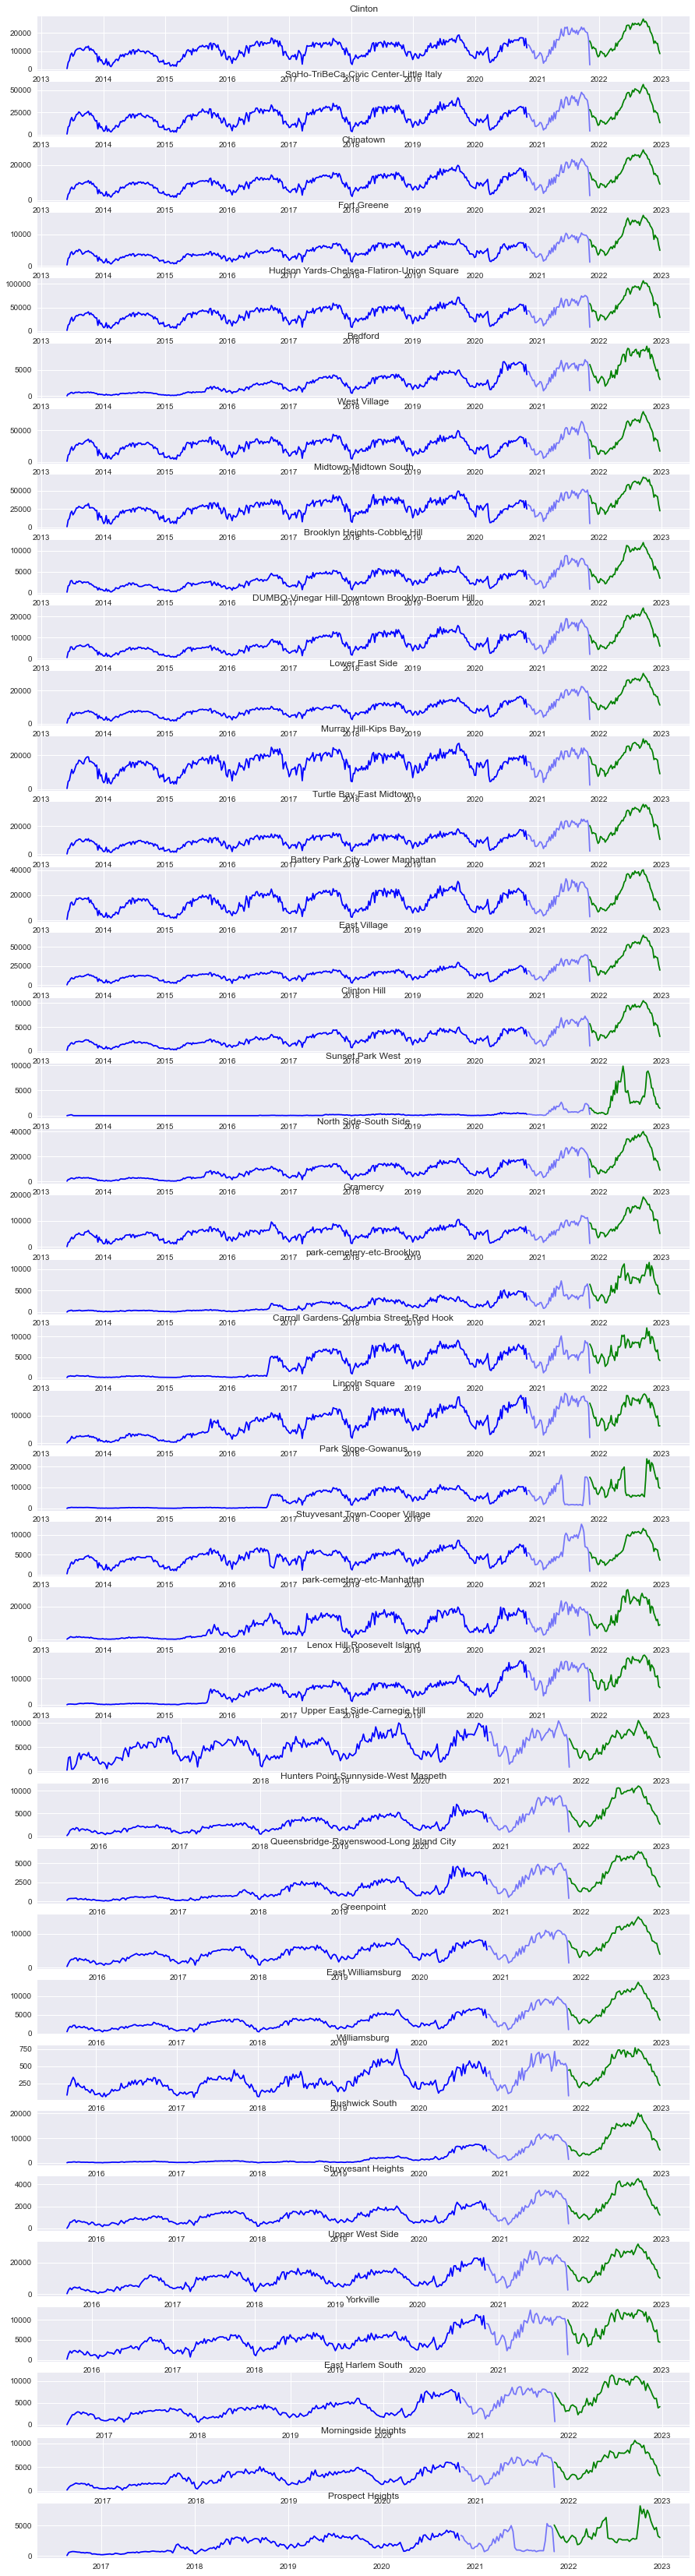

In [70]:
# Plot each of the predictions from these neighborhoods to sense check the results
# Everything looks reasonable. You can see the quirk at the end of the training set as the last week is shortened.

fig, ax = plt.subplots(nrows=(len(final_results.index)), figsize=(15,60))

for i, neighborhood in enumerate(final_results.index):
    ax[i].plot(df_dict[neighborhood].loc[df_dict[neighborhood].future == 0, 'ride_count'], color='blue')
    ax[i].plot(df_dict[neighborhood].loc[df_dict[neighborhood].future == 1, 'ride_count'], color='blue', 
               alpha=0.5)
    
    ax[i].plot(df_forecast.loc[:,neighborhood], color='green')
    ax[i].set_title(neighborhood)

The forecast understandably looks off for those few brooklyn neighborhoods (Park Slope, Prospect Heights, etc) where there was some sort of upstream data issue in 2021. Sorting this out will be a key next step.

In [71]:
# Create column to store 2022 predictions
df_results['2022_predicted'] = np.nan

# Filter forecast DF down to 2022 only
df_2022_forecast = df_forecast[(df_forecast.index > '12/31/2021') & (df_forecast.index < '12/31/2022')]

for neighborhood in neighborhood_list:
    final_results.loc[neighborhood, '2022_predicted'] = df_2022_forecast.loc[:,neighborhood].sum()

In [72]:
# Fill in the remaining two months from 2021 from the forecast so we can have a full year estimate

final_results['pro_rata_2021'] = np.nan

for neighborhood, df in df_dict.items():
    
    final_results.loc[neighborhood, 'pro_rata_2021'] = final_results.loc[neighborhood, '2021_actual'] + \
                                                            df_forecast[(df_forecast.index < '1/1/2022') & 
                                                                        (df_forecast.index > '10/31/2021')][neighborhood].sum()

In [73]:
# Add a 2022 forecast column to the results dataframe

final_results['forecast_2022'] = np.nan

for neighborhood, df in df_dict.items():
    final_results.loc[neighborhood, 'forecast_2022'] = df_forecast[(df_forecast.index > '12/31/2021')][neighborhood].sum()

In [74]:
# Add ride growth and % growth columns for 2022

final_results['delta_2022'] = final_results['forecast_2022'] - final_results['pro_rata_2021']

final_results['percent_chg_2022'] = (final_results['forecast_2022'] - final_results['pro_rata_2021']) / final_results['pro_rata_2021']

#### Overall Forecast

In [75]:
# Generate overall 2022 prediction

# Previously calibrated forecast steps to go through the end of 2022
forecast_steps = 60

overall_preds = pd.DataFrame(index=final_overall_model.forecast(steps=forecast_steps).index,
                             columns=['preds'])

overall_preds['preds'] = np.exp(final_overall_model.forecast(steps=forecast_steps))

pro_rata_2021 = weekly_ridership[weekly_ridership.index > '12/31/2020']['ride_count'].sum() + \
                overall_preds[(overall_preds.index > '10/31/2021') & (overall_preds.index < '1/1/2022')]['preds'].sum()

overall_2022 = overall_preds[overall_preds.index > '12/31/2021']['preds'].sum()

print(f"In 2021, there were {pro_rata_2021:,.0f} rides")
print("")
print(f"In 2022, there are forecast to be {overall_2022:,.0f} rides")

In 2021, there were 27,004,443 rides

In 2022, there are forecast to be 34,004,875 rides


In [76]:
# Show the overall growth rate from last year

(overall_2022 - pro_rata_2021) / pro_rata_2021

0.2592325747222365

## Conclusions

#### Final Overall Model

- The final overall model produces excellent results on the test set, with explained variance of 83%. 
- The downside to the hyperparemeters that produce this result is a very aggressive 2022 forecast.While the trend in the data does suggest this trajectory is reasonable, Citibike may run into logistical challenges in meeting this demand (they have already said there have been some struggles with record ridership in 2021 alone, see blog post reference in the EDA notebook summary).

**Key Results**

- Ridership is expected to shatter records in 2022. Peak ridership is forecast to be 1.1mm for a week, up from the previous record of 800,000. Total rides are forecast at 34mm, up from 27mm in 2021.
- Given the strains on the system already experienced in 2021, Citibike should hire additional staff, purchase more bikes, and build additional stations in the fastest growing neighborhoods (see neighborhood conclusions below) to meet this demand.

In [77]:
# Display the results from the final model on the Test set

results = report_metrics(test_weekly, weekly_future_df['best_seas'], True)

Explained Variance: 0.8286
MAE: 0.1607
RMSE: 0.2220
r^2: 0.8280


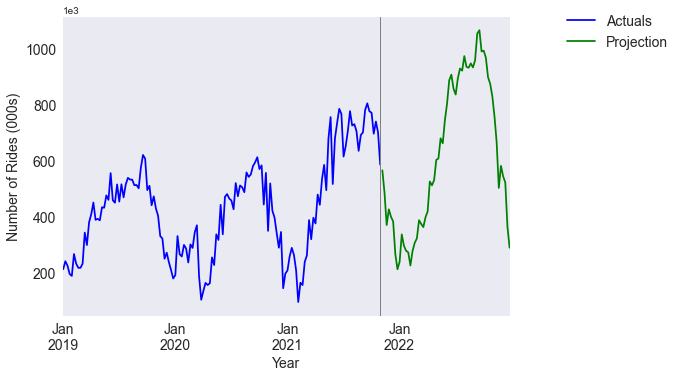

In [78]:
# Plot the 2022 projection on the fully trained model

fig, ax = plt.subplots()

actuals = weekly_ridership[weekly_ridership.index > '12/31/2018']
projections = final_overall_model.forecast(steps = 60)
projections = np.exp(projections[projections.index > '10/31/2021'])

actuals['ride_count'].plot(ax=ax, color='blue')
projections.plot(ax=ax, color='green')
ax.ticklabel_format(axis='y', style='sci', scilimits=(3,3))
ax.set_ylabel('Number of Rides (000s)', fontsize=14)
ax.set_xlabel('Year', fontsize=14)
ax.legend(['Actuals', 'Projection'], bbox_to_anchor=(1.1, 1.05), fontsize=14)
plt.axvline(x='10/31/2021', color='gray', linewidth=1)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
plt.minorticks_off()
ax.grid(False);

#### Neighborhood Models:

- Most neighborhoods have a model with an explained variance of at least 50%. For those models that continue to perform poorly, there are two explanations:
    - Midtown Manhattan neighborhoods where the model has failed to predict the extent of the post-COVID recovery
    - Adjacent neighborhoods around prospect park where there is an apparent data issue for a couple months in 2021 (which results in poor performance on the holdout test set)
- While I don't have a solution to the data issues in Brooklyn, one next step for the midtown neighborhood is to incorporate exogenous COVID variables, which will hopefully explain more of the recovery seen as the city opened up.

**Key Results**

- The top 5 neighborhoods in terms of overall ride growth are all in midtown Manhattan. This makes sense as these neighborhoods have the largest historical usage with the busiest stations.
- Meanwhile, the neighborhoods with the highest projected growth rate are found in Brooklyn around Prospect Park (Sunset Park, Park Slope, Prospect Heights, etc). Citibike should plan ahead for high growth in these neighborhoods by building additional stations to support this demand. 

**Next Steps / Improvements**

- Try to fix the 2021 data issue with the Brooklyn neighborhoods. This is causing issues with the forecast for a few neighborhoods.
- Incorporate exogenous COVID variables. The model is doing a poor job at forecasting the massive growth in midtown Manhattan neighborhoods as more people have returned to office.
- There are many additional analyses to be run here. As another next step, I want to go even more granular than the daily data, and aggregate by ridership in discrete blocks during the day (i.e., morning commute, midday, and evening commute). By also preserving the destination station data, you can start to paint a picture of how people move about the system at a much more granular level.

In [79]:
final_results.sort_values(by='explained_variance', ascending=False)[['explained_variance']]

,explained_variance
Battery Park City-Lower Manhattan,0.758413
North Side-South Side,0.749354
Bushwick South,0.735959
Stuyvesant Heights,0.722076
Hunters Point-Sunnyside-West Maspeth,0.715188
SoHo-TriBeCa-Civic Center-Little Italy,0.701641
Clinton Hill,0.700201
East Williamsburg,0.68835
West Village,0.676953
DUMBO-Vinegar Hill-Downtown Brooklyn-Boerum Hill,0.674736


In [80]:
# Sort values by change in ridership
# Midtown neighborhoods dominate the absolute ridership growth category

final_results.sort_values(by='delta_2022', ascending=False)[['delta_2022']].head()

,delta_2022
Hudson Yards-Chelsea-Flatiron-Union Square,899861.187712
East Village,769732.362278
Midtown-Midtown South,528986.528610
West Village,500142.031224
North Side-South Side,332965.292120


In [81]:
# Sort values by % change in ridership
# Many neighborhoods in Brooklyn, despite the data issues, have the highest projected % growth
# While this data issue may skew results, I feel comfortable in the % growth as the artificial dip
# In ridership is present in both the actuals and forecast (meaning % growth would likely be similar
# even with fixed data)

final_results.sort_values(by='percent_chg_2022', ascending=False)[['percent_chg_2022']].head()

,percent_chg_2022
Sunset Park West,2.655244
park-cemetery-etc-Brooklyn,0.812189
Park Slope-Gowanus,0.645063
Bushwick South,0.639487
Prospect Heights,0.621248


In [82]:
# 67% of neighborhood models achieve an EV of above 50%

high_perf = final_results[final_results['explained_variance'] >= 0.5].shape[0]

ratio = final_results[final_results['explained_variance'] >= 0.5].shape[0] / final_results.shape[0]

print(high_perf, ratio)

26 0.6666666666666666


## Addendum #1: COVID data

- The main models in this were trained on ridership data that included the downturn from the COVID-19 lockdowns in March / April 2020. Despite this anomaly, the ridership projection models were still able to achieve high accuracy.
- Adding in exogenous COVID-related controls allows for the building of sensitivity analyses. I.e., if we returned to March 2020 style lockdowns, what are the implications for 2022 ridership?
- To build this analysis, I relied on the NYC weekly recovery index, published by Investopedia here (https://www.investopedia.com/new-york-city-nyc-economic-recovery-index-5072042).
- I then built SARIMAX models that included this index, in particular, I used the Hospitalization, Subway Ridership, and Restaurant Reservations indices as the most meaningful predictors of bike ridership.
- For future projections, I created two lockdown scenarios, each lasting for two months at the beginning of 2022, followed by a gradual recovery:
    - Mild Lockdown: Index is cut in half, but nowhere near March 2020 levels. In this scenario, imagine indoor dining becomes restricted and more people work from home, but the city is not shut down.
    - Severe lockdown: This cuts the index to the level seen in March 2020. All in person dining is curtailed and all office employees are working from home.
- See the notebook saved at the link below for full modeling details. For this addendum, I will just import the results and plot the visuals.

https://github.com/marvelje/citibike_ridership_project/blob/main/support_notebooks/citibike_sarimax.ipynb

In [83]:
# Read in results

df_severe = pd.read_csv('./covid_results/forecast_severe.csv')
df_mild = pd.read_csv('./covid_results/forecast_mild.csv')
df_covid_scenarios = pd.read_csv('./covid_results/covid_scenarios.csv')

# Rename Unnamed column as date
df_severe.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_mild.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)
df_covid_scenarios.rename(columns={'Unnamed: 0': 'Date'}, inplace=True)

# Change date column to datetime
df_severe['Date'] = pd.to_datetime(df_severe['Date'])
df_mild['Date'] = pd.to_datetime(df_mild['Date'])
df_covid_scenarios['Date'] = pd.to_datetime(df_covid_scenarios['Date'])

# Set index to the date column
df_severe.set_index('Date', inplace=True)
df_mild.set_index('Date', inplace=True)
df_covid_scenarios.set_index('Date', inplace=True)

In [84]:
df_covid_scenarios.head()

,lin_recovery,flat,mild_lockdown,full_lockdown,hosp_subway_rest
Date,,,,,
2020-11-01,17.6,17.6,17.6,17.6,17.6
2020-11-08,16.7,16.7,16.7,16.7,16.7
2020-11-15,17.2,17.2,17.2,17.2,17.2
2020-11-22,15.6,15.6,15.6,15.6,15.6
2020-11-29,15.0,15.0,15.0,15.0,15.0


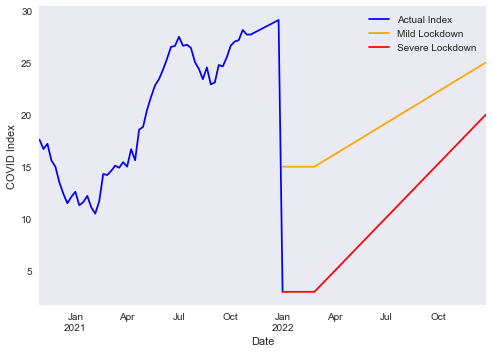

In [85]:
# Plot the COVID recovery index for the two scenarios. A lower number = more restrictive lockdown.
# For the Mild Scenario, the recovery index was cut in half before seeing a gradual recovery
# The for the Severe Scenario, the recovery index was dropped to March 2020 levels before beginning its recovery

fig, ax = plt.subplots();

mild = df_covid_scenarios[df_covid_scenarios.index > '12/31/2021']['mild_lockdown']
full = df_covid_scenarios[df_covid_scenarios.index > '12/31/2021']['full_lockdown']
actuals = df_covid_scenarios[df_covid_scenarios.index <= '1/2/2022']['full_lockdown']

actuals.plot(ax=ax, color='blue')
mild.plot(ax=ax, color='orange')
full.plot(ax=ax, color='red')

ax.grid(False)
ax.set_ylabel('COVID Index')
ax.set_xlabel('Date')
ax.legend(['Actual Index', 'Mild Lockdown', 'Severe Lockdown']);

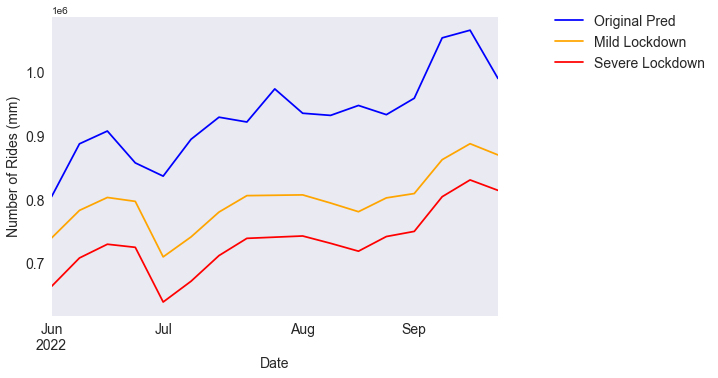

In [86]:
# Plot results for peak ridership months (June through September)

fig, ax = plt.subplots();

# Create separate dataframes for each scenario for the peak summer months
mild_summer = df_mild[(df_mild.index >= '6/1/2022') & (df_mild.index <= '9/30/2022')]['predicted_mean']
severe_summer = df_severe[(df_severe.index >= '6/1/2022') & (df_severe.index <= '9/30/2022')]['predicted_mean']
actuals_summer = overall_preds[(overall_preds.index >= '6/1/2022') & (overall_preds.index <= '9/30/2022')]['preds']

actuals_summer.plot(ax=ax, color='blue')
mild_summer.plot(ax=ax, color='orange')
severe_summer.plot(ax=ax, color='red')

ax.grid(False)
ax.set_ylabel('Number of Rides (mm)', fontsize=14)
ax.set_xlabel('Date', fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)
ax.legend(['Original Pred', 'Mild Lockdown', 'Severe Lockdown'], bbox_to_anchor=(1.1, 1.05), fontsize=14);

In [87]:
# % decrease for mild lockdown

(actuals_summer.sum() - mild_summer.sum()) / actuals_summer.sum()

0.1423349991452171

In [88]:
# % decrease for severe lockdown

(actuals_summer.sum() - severe_summer.sum()) / actuals_summer.sum()

0.21313899294128927

#### COVID results:

A mild lockdown for two months at the beginning of the year results in a 14% decrease in total summer ridership. For the severe lockdown, this results in a 21% decrease.

There are many ways to build these scenarios and measure the results, but this first pass does show that this variable is a meaningful indicator of ridership levels. I chose to evaluate the effect on total summer ridership as that's the most impactful number for Citibike. The peak summer month ridership places the most strain on the system, and knowing what this peak will look like has a meaningful impact on their business planning.

Citibike should use these sensitivity analyses to understand the implications of various COVID scenarios. There's a ripple effect to these indices. For example, this simulation modeled a lockdown for the first two months of the year, which has effects months down the road, even as the city recovers. The point is that Citibike has time to adjust system needs and yearly planning in the event of a lockdown.

## Addendum #2: Neighborhood plot

- The below creates the neighborhood summary visualizations for the deck.
- I will show two charts: total ridership growth and % growth

In [89]:
# Read in NYC shp file

nyc_zip = gpd.read_file('./nyc_geo_data/2010 Neighborhood Tabulation Areas (NTAs)/geo_export_a805ec3d-23e6-435e-b964-dd8c3b1c25de.shp')

In [90]:
# Pull all neighborhoods from the DF

full_neighborhood_list = list(df_citibike['neighborhood'].unique())

In [91]:
# Filter shp file for final list of 

nyc_zip_f = nyc_zip[nyc_zip['ntaname'].isin(full_neighborhood_list)]

In [92]:
# Merge the ridership numbers into the shp file

nyc_zip_f = nyc_zip_f.merge(final_results[['delta_2022', 'percent_chg_2022']], left_on='ntaname', right_index=True, how='left')

In [93]:
# Sense check the output

nyc_zip_f.head()

,boro_code,boro_name,county_fip,ntacode,ntaname,shape_area,shape_leng,geometry,delta_2022,percent_chg_2022
3,1.0,Manhattan,061,MN17,Midtown-Midtown South,3.019153e+07,27032.700375,"POLYGON ((-73.97301 40.76428, -73.97141 40.763...",528986.528610,0.291229
6,3.0,Brooklyn,047,BK69,Clinton Hill,2.052820e+07,23971.466236,"POLYGON ((-73.95337 40.68064, -73.95328 40.680...",105272.466982,0.433912
7,2.0,Bronx,005,BX26,Highbridge,1.645764e+07,18506.310104,"POLYGON ((-73.91729 40.84510, -73.91732 40.845...",NaN,NaN
12,2.0,Bronx,005,BX28,Van Cortlandt Village,2.566612e+07,21945.719672,"POLYGON ((-73.88705 40.88435, -73.88705 40.884...",NaN,NaN
14,3.0,Brooklyn,047,BK40,Windsor Terrace,1.404167e+07,19033.671936,"POLYGON ((-73.98017 40.66115, -73.98021 40.661...",NaN,NaN


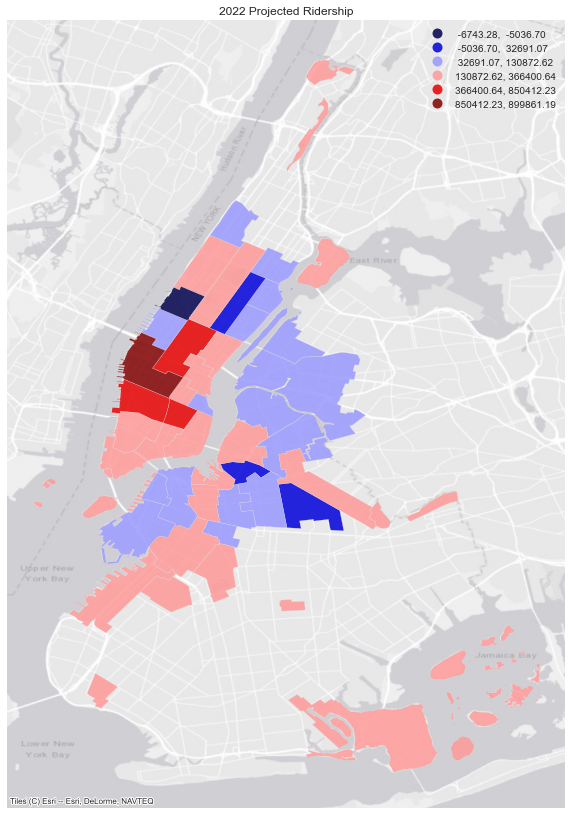

In [94]:
# Plot the results of total change in ridership

fig, ax = plt.subplots(figsize=(10,15))

nyc_zip_f.plot(ax=ax, column = 'delta_2022', scheme = 'Percentiles', k=10, vmin = 0, cmap = 'seismic',
               edgecolor= 'gainsboro', alpha=.85, legend = True)
cx.add_basemap(ax, crs=nyc_zip.crs, source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title("2022 Projected Ridership")
ax.axis('off');

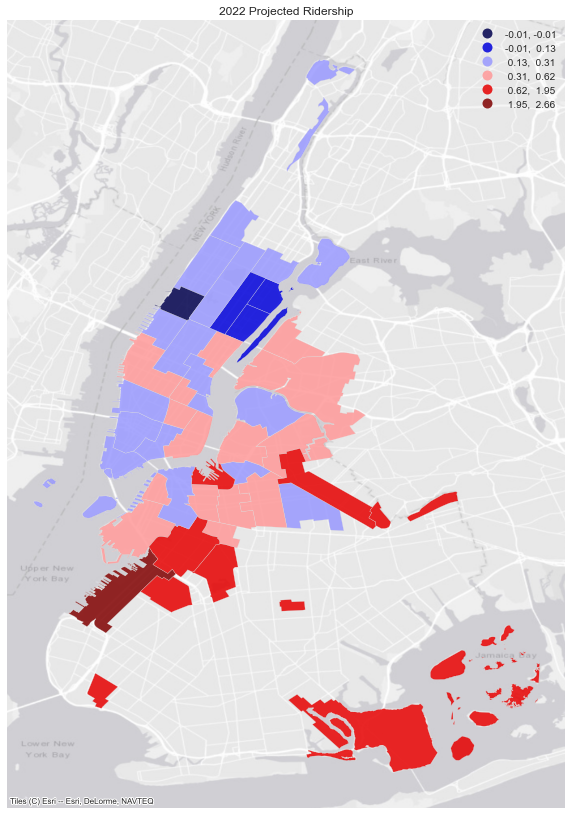

In [95]:
# Plot the results of total change in ridership

fig, ax = plt.subplots(figsize=(10,15))

nyc_zip_f.plot(ax=ax, column = 'percent_chg_2022', scheme = 'Percentiles', k=10, vmin = 0, cmap = 'seismic',
               edgecolor= 'gainsboro', alpha=.85, legend = True)
cx.add_basemap(ax, crs=nyc_zip.crs, source=cx.providers.Esri.WorldGrayCanvas)
ax.set_title("2022 Projected Ridership")
ax.axis('off');

In [96]:
# Sort by top neighborhoods for total change

final_results.sort_values(by='delta_2022', ascending=False)

,model,order,seasonal_order,explained_variance,MAE,MSE,R2,2021_actual,2021_predicted,delta,requires_log,2022_predicted,pro_rata_2021,forecast_2022,delta_2022,percent_chg_2022
Hudson Yards-Chelsea-Flatiron-Union Square,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 2)","(1, 1, 1, 52)",0.531315,0.342462,0.440341,0.360459,2190634,1676196.61423,514437.38577,True,3.420943e+06,2.521082e+06,3.420943e+06,899861.187712,0.356935
East Village,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 2)","(1, 1, 1, 52)",0.601976,0.419245,0.503409,0.251837,1116657,742902.216487,373754.783513,True,2.075059e+06,1.305327e+06,2.075059e+06,769732.362278,0.589686
Midtown-Midtown South,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 2)","(1, 1, 1, 52)",0.357645,0.496374,0.576979,-0.199033,1562113,974033.065542,588079.934458,True,2.345379e+06,1.816392e+06,2.345379e+06,528986.528610,0.291229
West Village,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 1, 52)",0.676953,0.378094,0.45012,0.520533,1571664,1171205.511703,400458.488297,True,2.265382e+06,1.765240e+06,2.265382e+06,500142.031224,0.283328
North Side-South Side,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.749354,0.224485,0.346032,0.72161,788758,717473.121709,71284.878291,True,1.215147e+06,8.821822e+05,1.215147e+06,332965.292120,0.377434
Turtle Bay-East Midtown,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 2)","(1, 1, 1, 52)",0.515346,0.413222,0.500096,0.195953,753899,514642.431351,239256.568649,True,1.196278e+06,8.697812e+05,1.196278e+06,326497.178627,0.375379
SoHo-TriBeCa-Civic Center-Little Italy,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 1, 1, 52)",0.701641,0.332055,0.413604,0.561385,1266160,989374.184704,276785.815296,True,1.711603e+06,1.424010e+06,1.711603e+06,287592.989762,0.201960
Lower East Side,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 1, 1, 52)",0.669793,0.283168,0.358698,0.539026,653088,521913.706366,131174.293634,True,1.012810e+06,7.529751e+05,1.012810e+06,259834.476543,0.345077
Battery Park City-Lower Manhattan,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 0)","(0, 1, 1, 52)",0.758413,0.274615,0.370913,0.696913,892953,740710.036131,152242.963869,True,1.242705e+06,9.927538e+05,1.242705e+06,249951.269076,0.251776
Bushwick South,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 1)","(0, 1, 1, 52)",0.735959,0.241793,0.390559,0.68411,312183,362517.068537,50334.068537,True,5.761029e+05,3.513922e+05,5.761029e+05,224710.729147,0.639487


In [97]:
# Sort by top neighborhoods for percent change

final_results.sort_values(by='percent_chg_2022', ascending=False)

,model,order,seasonal_order,explained_variance,MAE,MSE,R2,2021_actual,2021_predicted,delta,requires_log,2022_predicted,pro_rata_2021,forecast_2022,delta_2022,percent_chg_2022
Sunset Park West,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 1)","(0, 1, 0, 52)",0.634686,0.5484,0.663434,0.587454,47977,36008.880906,11968.119094,True,2.016187e+05,5.515876e+04,2.016187e+05,146459.969522,2.655244
park-cemetery-etc-Brooklyn,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 0, 52)",0.313265,0.355432,0.432276,0.306627,167600,160941.281736,6658.718264,True,3.654283e+05,2.016502e+05,3.654283e+05,163778.048587,0.812189
Park Slope-Gowanus,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 0, 52)",-0.462873,0.827196,0.989632,-0.572422,263480,280459.588277,16979.588277,True,5.725299e+05,3.480290e+05,5.725299e+05,224500.820634,0.645063
Bushwick South,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(1, 1, 1)","(0, 1, 1, 52)",0.735959,0.241793,0.390559,0.68411,312183,362517.068537,50334.068537,True,5.761029e+05,3.513922e+05,5.761029e+05,224710.729147,0.639487
Prospect Heights,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 0, 52)",-0.630304,0.748631,0.913837,-0.926238,96257,124709.01649,28452.01649,True,2.011093e+05,1.240460e+05,2.011093e+05,77063.349298,0.621248
East Village,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 2)","(1, 1, 1, 52)",0.601976,0.419245,0.503409,0.251837,1116657,742902.216487,373754.783513,True,2.075059e+06,1.305327e+06,2.075059e+06,769732.362278,0.589686
Gramercy,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 1, 52)",0.522091,0.377459,0.469123,0.253828,321283,236651.882976,84631.117024,True,5.711079e+05,3.744811e+05,5.711079e+05,196626.813187,0.525065
Fort Greene,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(1, 1, 1, 52)",0.553827,0.359819,0.450876,0.349409,309627,236223.637078,73403.362922,True,5.246969e+05,3.582437e+05,5.246969e+05,166453.227325,0.464637
Clinton Hill,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 0)","(0, 1, 1, 52)",0.700201,0.322951,0.392584,0.535193,210796,162580.621735,48215.378265,True,3.478850e+05,2.426126e+05,3.478850e+05,105272.466982,0.433912
North Side-South Side,<statsmodels.tsa.statespace.sarimax.SARIMAXRes...,"(0, 1, 1)","(0, 1, 1, 52)",0.749354,0.224485,0.346032,0.72161,788758,717473.121709,71284.878291,True,1.215147e+06,8.821822e+05,1.215147e+06,332965.292120,0.377434
